In [69]:
# 1. Install Transformers (if not already installed)
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [70]:
!pip install transformers datasets accelerate peft -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [71]:
pip install --upgrade pip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


#Importing required libraries

In [72]:
from transformers import AutoTokenizer,AutoModelForCausalLM, BitsAndBytesConfig

In [73]:
!pip install transformers accelerate peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [74]:
import pandas as pd
import numpy as np

print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)

Pandas version: 2.2.3
Numpy version: 2.0.2


In [75]:
import os
print(os.path.exists("/kaggle/input/clinical-reasoning-dataset/train.csv"))


True


In [76]:
import pandas as pd

train_df = pd.read_csv("/kaggle/input/clinical-reasoning-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/clinical-reasoning-dataset/test.csv")

In [77]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Master_Index         400 non-null    object 
 1   County               400 non-null    object 
 2   Health level         400 non-null    object 
 3   Years of Experience  300 non-null    float64
 4   Prompt               400 non-null    object 
 5   Nursing Competency   400 non-null    object 
 6   Clinical Panel       400 non-null    object 
 7   Clinician            400 non-null    object 
 8   GPT4.0               400 non-null    object 
 9   LLAMA                400 non-null    object 
 10  GEMINI               400 non-null    object 
 11  DDX SNOMED           399 non-null    object 
dtypes: float64(1), object(11)
memory usage: 37.6+ KB


In [78]:
train_df.columns

Index(['Master_Index', 'County', 'Health level', 'Years of Experience',
       'Prompt', 'Nursing Competency', 'Clinical Panel', 'Clinician', 'GPT4.0',
       'LLAMA', 'GEMINI', 'DDX SNOMED'],
      dtype='object')

In [79]:

train_df.drop('Master_Index', axis=1, inplace=True) 

In [80]:
train_df.isnull().sum()

County                   0
Health level             0
Years of Experience    100
Prompt                   0
Nursing Competency       0
Clinical Panel           0
Clinician                0
GPT4.0                   0
LLAMA                    0
GEMINI                   0
DDX SNOMED               1
dtype: int64

<Axes: xlabel='Years of Experience', ylabel='Count'>

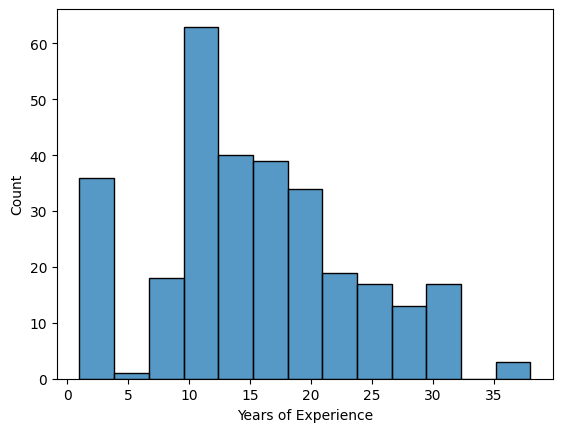

In [81]:
import seaborn as sns
sns.histplot(data=train_df, x='Years of Experience')

In [82]:
median_exp = train_df["Years of Experience"].median()
train_df["Years of Experience"] = train_df["Years of Experience"].fillna(median_exp)

In [83]:
train_df.isnull().sum()

County                 0
Health level           0
Years of Experience    0
Prompt                 0
Nursing Competency     0
Clinical Panel         0
Clinician              0
GPT4.0                 0
LLAMA                  0
GEMINI                 0
DDX SNOMED             1
dtype: int64

In [84]:
def build_context(row):
    return (
        f"County: {row['County']}, "
        f"Health level: {row['Health level']}, "
        f"Years of Experience: {row['Years of Experience']}, "
        f"Nursing Competency: {row['Nursing Competency']}, "
        f"Clinical Panel: {row['Clinical Panel']}"
    )

train_df["Context"] = train_df.apply(build_context, axis=1)

# Construct the final SLM input prompt
train_df["Input"] = "Context: " + train_df["Context"] + "\nPrompt: " + train_df["Prompt"]

# Define target output
train_df["Target"] = train_df["Clinician"]

# Drop rows where Target is missing
train_df = train_df[train_df["Target"].notna()]

# Save for training
train_df[["Input", "Target"]].to_csv("formatted_train_data.csv", index=False)

# example prompt

In [85]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "google/flan-t5-small"

# Load model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Define prompt
prompt = """
Context: County: Kisumu, Health level: Level 3, Years of Experience: 10, Nursing Competency: High
Prompt: A 22-year-old woman presents with fever, abdominal pain, and delayed menstruation.
What would the clinician do?
"""

# Tokenize
inputs = tokenizer(prompt, return_tensors="pt")

# Generate
outputs = model.generate(**inputs, max_new_tokens=100)

# Decode and print
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

perform a syringe treatment.


In [86]:
# Step 1: Load your formatted dataset
# Check first if the file exists
import os

if os.path.exists("/kaggle/input/input-output-formatted-csv/formatted_train_data.csv"):
    train_df_clean = pd.read_csv("/kaggle/input/input-output-formatted-csv/formatted_train_data.csv")
    print("Loaded successfully.")
else:
    print("File not found. Please ensure it was written in a previous step.")



Loaded successfully.


In [93]:
from datasets import Dataset

# Convert your cleaned DataFrame to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_clean[["Input", "Target"]])

In [94]:
# Step 2: Load FLAN-T5 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [95]:
max_input_length = 512
max_target_length = 128

def preprocess(example):
    model_input = tokenizer(
        example["Input"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )
    labels = tokenizer(
        example["Target"],
        max_length=max_target_length,
        truncation=True,
        padding="max_length",
    )
    model_input["labels"] = labels["input_ids"]
    return model_input

tokenized_dataset = train_dataset.map(preprocess, batched=True)


Map: 100%|██████████| 400/400 [00:00<00:00, 2383.28 examples/s]


In [96]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [97]:
example = {
    "Input": ["Context: County: Nairobi...\nPrompt: A 34-year-old..."],
    "Target": ["Prescribe antibiotics and refer."]
}

In [ ]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/flan-t5-clinician",     # where to save model
                         # disable eval during training
    per_device_train_batch_size=4,
    num_train_epochs=3,
    save_total_limit=1,                                 # keep only last checkpoint
    save_steps=500,
    logging_dir="/kaggle/working/logs",
    logging_steps=100,
    fp16=True,                                         # True if using FP16 GPU like T4/V100
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


/tmp/ipykernel_10/1889173795.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


In [ ]:
trainer.save_model("/kaggle/working/flan-t5-clinician")
tokenizer.save_pretrained("/kaggle/working/flan-t5-clinician")